## 13 - How to make use of Coiled service for parallel computing
### A DeepESDL example notebook 

This notebook gives an example how to make use of coiled integration. Coiled allows easy, secure and efficient computing with Dask. It allows you to parrallelise your workflows and to spin up a cluster with a desired number of workers to run the workflow. So you actually can run workflows that require more computational resources than you have locally (or here in your DeepESDL workspace) and coiled is taking care of setting up the cluster, installing the envrionment on the worker nodes. Dask then takes care of the parrallel computation. After a task is finished, and you do not need the resources anymore, you shut down the cluster with a single line of code and coiled ensures that all resources are shut down. 

To find out more about [Coiled](https://www.coiled.io/). 
**If you are new to dask, please make sure to read up on [dask](https://www.dask.org/get-started) first, before starting to run workflows with coiled.**

Please, also refer to the [DeepESDL documentation](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/) and visit the platform's [website](https://www.earthsystemdatalab.net/) for further information!

Brockmann Consult, 2023

-----------------

**To run this notebook you need a python environment with:**
- xcube>=1.1.2
- coiled
- dask
- distributed=2023.7.1
- ipykernel

To create a custom envrionment, please refert to the [documentation](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/#creating-custom-team-python-environment).

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;">
<font size="+0.5">To get access to the coiled service, please contact the DeepESDL team and they will help you to apply for funding. The example notebook will only run if your team has already access to the coiled service and a suitable envrionment is selected.</font>
</div>

If your team has access to coiled, you have to execute the following line once in your terminal:   
`$ coiled login --account bc --token $COILED_TOKEN`

You just need to do this on the very first usage.

In [1]:
from xcube.util.dask import new_cluster
from dask.distributed import Client
import os

In [2]:
# This is mandatory, so coiled mirrors your currently slected environment 
# and does not take the default environment
del os.environ['JUPYTER_IMAGE']

Before starting a cluster with Coiled, think about a good cluster name, as well as how many workers you expect to need for your task. 

The meaningful clustername is helpful in case for some reason your jupyter notebook crashes or you wish to connect to a running cluster from another notebook. It will then recognise that a cluster with the indicated name is already running and connect to it. 

Below creates a cluster with 2 worker nodes of the default instance type (spot instances). For more settings please refer to the [coiled documentation](https://docs.coiled.io/user_guide/api.html#clusters). You can use the same parameters in xcubes new_cluster, which is a wrapper around the coiled cluster function and allows us (DeepESDL Team) to pass some deault settings which are mandatory for our monitoring and security access. **Please do not use coiled.Cluster directly <- if you do, we will find you and it will be very unpleasant expericence for you!**

Whenever you start a cluster, please make sure to shut it down with `cluster.shutdown()` once finished! If not, your processing units will dissapear without you making use of them.  

In [3]:
# default instance type selected contains 4 cores
cluster = new_cluster(name='team_wonderful_computing_monthly_means', n_workers=2)


Output()

Output()

Connect your newly started cluster to the dask client:

In [4]:
# check cluster status
cluster.status

<Status.running: 'running'>

In [5]:
client = Client(cluster)

To see the coiled cluster in action, lets create monthly means from the earth system data cube provided by DeepESDL for a variable. To get more inspiration, when dask may be handy, check out the [example section](https://examples.dask.org/xarray.html).

In [6]:
from xcube.core.store import new_data_store
store = new_data_store("s3", root="deep-esdl-public", storage_options=dict(anon=True))
store.list_data_ids()

['LC-1x2160x2160-1.0.0.levels',
 'SMOS-freezethaw-1x720x720-1.0.1.zarr',
 'SMOS-freezethaw-4267x10x10-1.0.1.zarr',
 'black-sea-1x1024x1024.levels',
 'black-sea-256x128x128.zarr',
 'esa-cci-permafrost-1x1151x1641-0.0.2.levels',
 'esdc-8d-0.25deg-1x720x1440-3.0.1.zarr',
 'esdc-8d-0.25deg-256x128x128-3.0.1.zarr',
 'ocean-1M-9km-1x1080x1080-1.4.0.levels',
 'ocean-1M-9km-64x256x256-1.4.0.zarr',
 'polar-100m-1x2048x2048-1.0.1.zarr']

Because we plan to create monthly means, which will benifit from the time optimized cube chunking, we select the cube, which contains 256 timestamps in one chunk:

In [7]:
dataset = store.open_data('esdc-8d-0.25deg-256x128x128-3.0.1.zarr')

In [8]:
dataset

<xarray.Dataset>
Dimensions:                            (time: 1978, lat: 720, lon: 1440)
Coordinates:
  * lat                                (lat) float64 -89.88 -89.62 ... 89.88
  * lon                                (lon) float64 -179.9 -179.6 ... 179.9
  * time                               (time) datetime64[ns] 1979-01-05 ... 2...
Data variables: (12/42)
    aerosol_optical_thickness_550      (time, lat, lon) float32 dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    air_temperature_2m                 (time, lat, lon) float32 dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    bare_soil_evaporation              (time, lat, lon) float32 dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    burnt_area                         (time, lat, lon) float64 dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    cot                                (time, lat, lon) float32 dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    cth                                (time, lat, lon) float32 dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    ...                                 ...
    sif_rtsif                          (time, lat, lon) float32 dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    sm                                 (time, lat, lon) float32 dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    snow_sublimation                   (time, lat, lon) float32 dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    surface_moisture                   (time, lat, lon) float32 dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    terrestrial_ecosystem_respiration  (time, lat, lon) float32 dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    transpiration                      (time, lat, lon) float32 dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

Select a variable, for which you would like to calculate monthly means. Here we select air_temperature_2m.

In [9]:
air_dataset = dataset[['air_temperature_2m']]
air_dataset

<xarray.Dataset>
Dimensions:             (time: 1978, lat: 720, lon: 1440)
Coordinates:
  * lat                 (lat) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                 (lon) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time                (time) datetime64[ns] 1979-01-05 ... 2021-12-31
Data variables:
    air_temperature_2m  (time, lat, lon) float32 dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

Next, we specify how the dataset should be resampled. Note, that this is a lazy operation. When you have a look at air_dataset_monthly after executing the below cell, you will see aready the metadata and the structure of the data as expected to contain for each month only one value - but actually no resampling of the data has happened so far. 

In [10]:
air_dataset_monthly = air_dataset.resample({'time':'1M'}).mean()

In [11]:
# the metadata already looks as expected, but note: no data has been resampled yet!
air_dataset_monthly

<xarray.Dataset>
Dimensions:             (time: 516, lat: 720, lon: 1440)
Coordinates:
  * lat                 (lat) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                 (lon) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time                (time) datetime64[ns] 1979-01-31 ... 2021-12-31
Data variables:
    air_temperature_2m  (time, lat, lon) float32 dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

Now we want to execute the monthly resampling, to then use the data in further analysis. 

The below will command take a moment. You can see the progress of the taskby clicking on the link "Dashboard Address" provided in the coiled cluster overview on the top.

In [13]:
computed_air_dataset_monthly = air_dataset_monthly.compute()


In [14]:
computed_air_dataset_monthly

<xarray.Dataset>
Dimensions:             (time: 516, lat: 720, lon: 1440)
Coordinates:
  * lat                 (lat) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                 (lon) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time                (time) datetime64[ns] 1979-01-31 ... 2021-12-31
Data variables:
    air_temperature_2m  (time, lat, lon) float32 -30.6 -30.6 ... -23.28 -23.28
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

**Once you are finished with your computations, make sure to shutdown the cluster to minimize costs.**

In [15]:
cluster.shutdown()

Note, resampling by month, will alsways put the date for the month on the last day of the month per default.

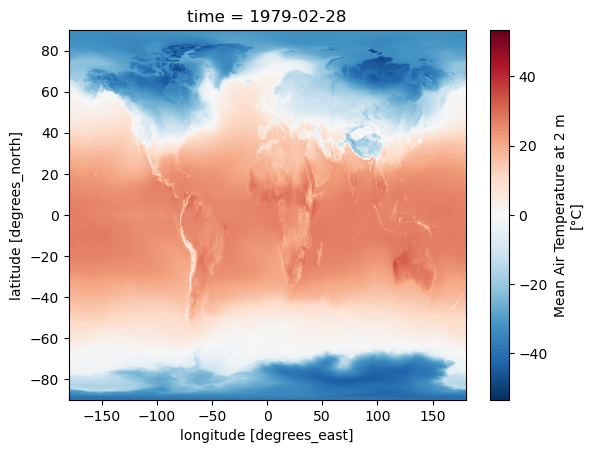

In [16]:
computed_air_dataset_monthly.air_temperature_2m.isel(time=1).plot.imshow()

If you wish to persist the dataset to your team storage, please checkout the example notebook 05 SAVE CUBE TO TEAM STORAGE.